In [53]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm
from scipy.optimize import curve_fit

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from src.utils.constants import *
from src.utils.CosmoFunc import *
from src.utils.functions import density_contour

In [24]:
# Load mock data
df = pd.read_csv("../../data/mocks/mock_galaxies/all_combined_mocks_smin_1_fp_fit_method_0.txt", delim_whitespace=True)
df["mock_id"] = df["#mockgal_ID"].apply(lambda x: int(x.split("_")[1]))
df = df[df["mock_id"] == 1]
df['z'] = df['cz'] / LightSpeed
df['C_m'] = 1.0

df.head()

,#mockgal_ID,r,s,i,dr,dr_ph,ds,di,Sprob,mag_j,absmag_j,kcorr,extinction_j,cz,mock_id,z,C_m
0,1_1,0.855,2.400,2.800,0.0178,0.00903,0.0319,0.0357,1.000,11.300,-24.500,0.0333,0.0267,14279.4,1,0.047631,1.0
1,2_1,0.448,2.396,3.074,0.0130,0.02100,0.0080,0.0250,1.000,10.790,-23.162,0.0140,0.0740,6077.2,1,0.020271,1.0
2,3_1,0.342,2.249,3.005,0.0380,0.01100,0.0370,0.0760,1.000,12.931,-22.512,0.0280,0.0070,11904.9,1,0.039710,1.0
3,4_1,0.195,2.341,3.251,0.0430,0.00900,0.0350,0.0870,0.852,13.423,-22.353,0.0320,0.0450,13811.6,1,0.046071,1.0
4,5_1,0.484,2.183,2.926,0.0360,0.00900,0.0220,0.0730,1.000,12.799,-22.980,0.0320,0.0460,13826.2,1,0.046119,1.0


In [12]:
# Load FP fit
fp_fit = pd.read_csv("../../artifacts/mock_fits/smin_setting_1/fp_fit_method_0/all_combined_fit_with_full_fn.csv")
fp_fit = fp_fit[fp_fit["mock_id"] == 1][fp_fit.columns[1:]].to_numpy()[0]

fp_fit

array([ 1.46665708, -0.90801497,  0.13474151,  2.23989513,  3.22115861,
        0.04569645,  0.28950953,  0.15798207])

In [33]:
def fit_logdist(
        survey: str,
        df: pd.DataFrame,
        smin: float,
        FPlabel: str,
        FPparams: np.ndarray,
        use_full_fn: bool = True,
        mag_high: float = MAG_HIGH,
        mag_low: float = MAG_LOW,
    ) -> pd.DataFrame:
    """
    This is a function to calculate the log-distance ratio posteriors and obtain summary statistics.
    Summary statistics are obtained using two methods: direct calculation assuming skew-normal and 
    fitting using scipy's curve_fit assuming Gaussian.
    """

    # Get some redshift-distance lookup tables
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    dz_cluster = sp.interpolate.splev(df["z"], dist_spline)

    # Define the range of logdists values to be calculated
    dmin, dmax, nd = -1.5, 1.5, 1001
    dbins = np.linspace(dmin, dmax, nd, endpoint=True)

    # Calculate full FN
    d_H = np.outer(10.0**(-dbins), dz_cluster)
    lmin = (SOLAR_MAGNITUDE['j'] + 5.0 * np.log10(1.0 + df["z"].to_numpy()) + df["kcorr"].to_numpy() + df["extinction_j"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - mag_high) / 5.0
    lmax = (SOLAR_MAGNITUDE['j'] + 5.0 * np.log10(1.0 + df["z"].to_numpy()) + df["kcorr"].to_numpy() + df["extinction_j"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - mag_low) / 5.0
    
    df['r_true'] = df['r']

    # Calculate log-likelihood
    loglike = FP_func(FPparams, dbins, df["z"].to_numpy(), df["r_true"].to_numpy(), df["s"].to_numpy(), df["i"].to_numpy(), df["dr"].to_numpy(), df["ds"].to_numpy(), df["di"].to_numpy(), np.ones(len(df)), smin, lmin, lmax, df["C_m"].to_numpy(), sumgals=False, use_full_fn=use_full_fn)

    # Calculate full FN
    FNvals = FN_func(FPparams, df["z"].to_numpy(), df["dr"].to_numpy(), df["ds"].to_numpy(), df["di"].to_numpy(), lmin, lmax, smin)

    # Convert to the PDF for logdistance
    logP_dist = -1.5 * np.log(2.0 * math.pi) - loglike - FNvals

    # normalise logP_dist (trapezoidal rule)
    ddiff = np.log10(d_H[:-1]) - np.log10(d_H[1:])
    valdiff = np.exp(logP_dist[1:]) + np.exp(logP_dist[0:-1])
    norm_ = 0.5 * np.sum(valdiff * ddiff, axis=0)

    logP_dist -= np.log(norm_[:, None]).T

    # Calculate the mean and standard deviation of the distribution
    mean = np.sum(dbins[0:-1,None]*np.exp(logP_dist[0:-1])+dbins[1:,None]*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0
    err = np.sqrt(np.sum(dbins[0:-1,None]**2*np.exp(logP_dist[0:-1])+dbins[1:,None]**2*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - mean**2)

    # Calculate the skewness and cap it
    gamma1 = (np.sum(dbins[0:-1,None]**3*np.exp(logP_dist[0:-1])+dbins[1:,None]**3*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - 3.0*mean*err**2 - mean**3)/err**3
    gamma1 = np.where(gamma1 > 0.99, 0.99, gamma1)
    gamma1 = np.where(gamma1 < -0.99, -0.99, gamma1)

    # Calculate the parameters of skew-normal distribution
    delta = np.sign(gamma1)*np.sqrt(np.pi/2.0*1.0/(1.0 + ((4.0 - np.pi)/(2.0*np.abs(gamma1)))**(2.0/3.0)))
    scale = err * np.sqrt(1.0 / (1.0 - 2.0 * delta**2 / np.pi))
    loc = mean - scale * delta * np.sqrt(2.0 / np.pi)
    alpha = delta / (np.sqrt(1.0 - delta**2))

    # # Store the skew-normal values calculated analytically to the dataframe
    # df[f"logdist_mean_{FPlabel.lower()}"] = mean
    # df[f"logdist_std_{FPlabel.lower()}"] = err
    # df[f"logdist_alpha_{FPlabel.lower()}"] = alpha
    # df[f"logdist_loc_{FPlabel.lower()}"] = loc
    # df[f"logdist_scale_{FPlabel.lower()}"] = scale

    # Transpose the PDF and return to linear unit
    y = np.exp(logP_dist.T)

    # Find mean and standard deviation of the distribution using curve_fit
    logdist_mean = []
    logdist_std = []
    chisq = []
    rmse = []
    for i, y_ in enumerate(y):
        popt, pcov = curve_fit(gaus, dbins, y_, p0=[mean[i], err[i]])
        popt[1] = np.absolute(popt[1])
        logdist_mean.append(popt[0])
        logdist_std.append(popt[1])

        # Calculate the chi-squared statistic for the fit
        ypred = norm.pdf(dbins, popt[0], popt[1])
        chisquare = np.sum((y_ - ypred)**2 / ypred, axis=0)
        chisq.append(chisquare)

        # Calculate RMSE statistic for the fit
        ypred = norm.pdf(dbins, popt[0], popt[1])
        rmse_ = np.sqrt((1 / dbins.shape[0]) * np.sum((y_ - ypred)**2, axis=0))
        rmse.append(rmse_)

    df[f'logdist_{FPlabel.lower()}'] = logdist_mean
    df[f'logdist_err_{FPlabel.lower()}'] = logdist_std
    df[f'logdist_chisq_{FPlabel.lower()}'] = chisq
    df[f'logdist_rmse_{FPlabel.lower()}'] = rmse
    
    return df

In [34]:
df_logdist = fit_logdist(
    survey="ALL_COMBINED",
    df=df,
    smin=SURVEY_VELDISP_LIMIT[1]['6dFGS'],
    FPlabel='all_combined',
    FPparams=fp_fit,
    use_full_fn=True
)

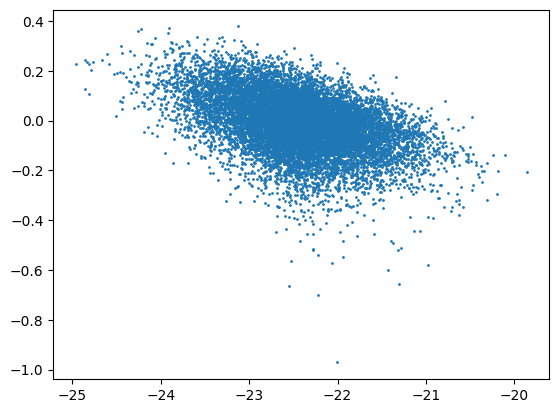

In [32]:
plt.scatter(df_logdist["absmag_j"], df_logdist["logdist_all_combined"], s=1)

# Combine @10% of data

In [37]:
df = pd.DataFrame()
for file in os.listdir('./results/'):
    
    if not file.endswith(".csv"):
        continue

    df_ = pd.read_csv(f'./results/{file}').sample(frac=0.1)

    df = pd.concat([df, df_])

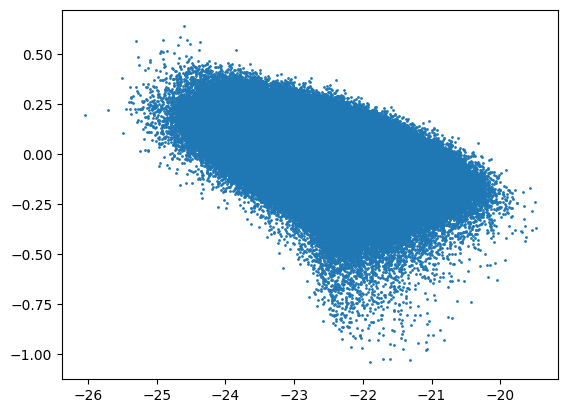

In [39]:
plt.scatter(df['absmag_j'], df['logdist'], s=1)

In [40]:
df.to_csv('./mocks_all_combined.csv', index=False)

In [44]:
df_ = pd.DataFrame()
for survey in ['6dfgs', 'sdss', 'lamost']:
    df_temp = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey}.csv")

    df_ = pd.concat([df_, df_temp])



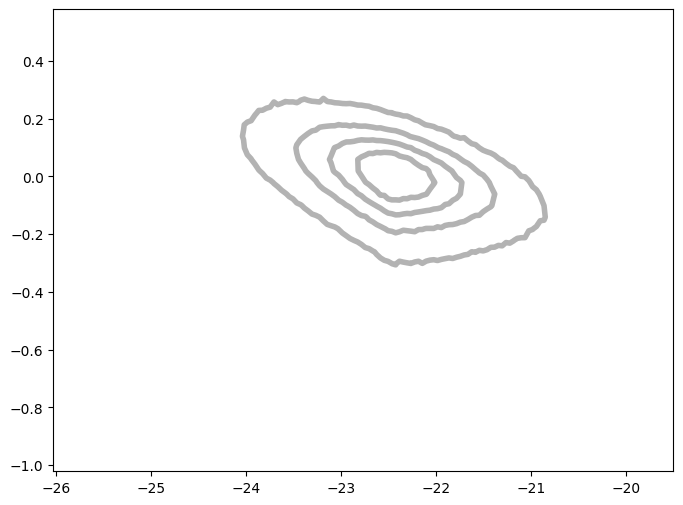

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

mock_cmap = plt.get_cmap("gray")
levels_plot_mock = [(0.25, (0.04, 0.04), mock_cmap(0.7)), (0.5, (0.04, 0.04), mock_cmap(0.7)), (0.75, (0.04, 0.04), mock_cmap(0.7)), (0.95, (0.04, 0.04), mock_cmap(0.7))]

density_contour(df['absmag_j'].to_numpy(), df['logdist'].to_numpy(), bins_levels_tuple_list=levels_plot_mock, ax=ax, linewidths=4.0, linestyles="-")



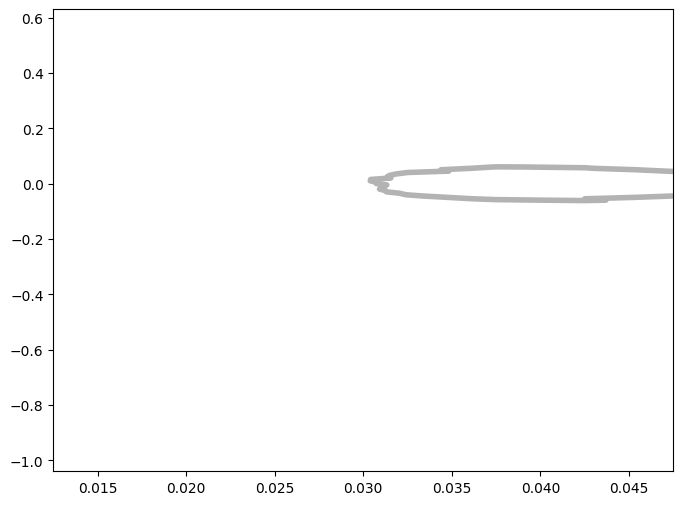

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

df['z'] = df['cz'] / LightSpeed

mock_cmap = plt.get_cmap("gray")
levels_plot_mock = [(0.25, (0.005, 0.005), mock_cmap(0.7))]

density_contour(df['z'].to_numpy(), df['logdist'].to_numpy(), bins_levels_tuple_list=levels_plot_mock, ax=ax, linewidths=4.0, linestyles="-")

In [50]:
df['cz'].to_numpy() / LightSpeed

array([0.04776171, 0.03360992, 0.02690495, ..., 0.04675201, 0.02653536,
       0.03603393])